
**Date:** 31 March 2022<br>
**Goal:** Now that we have a much more refined and constrained series of SCAM experiments, with and without the effects of HTG, can we recreate the budget analysis for various terms to understand what's happening more fully? <br>

In [1]:
# Load libraries

# # Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.ticker as ticker 
import matplotlib.patches as patches
import matplotlib as matplotlib
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Analysis
import numpy as np 
import xarray as xr
import datetime
from   datetime import date, timedelta
import pandas as pd 
import scipy.stats as stats
import time
import pickle

# Import Ngl with pyn_env active 
import Ngl

import warnings
warnings.filterwarnings('ignore')


## Read in data 

In [2]:
## Load data rather than re-create (it takes a long time to read it all in) 
saveDir = '/glade/work/mdfowler/CLASP/histData/processedData/ens_byLeadDay/'

hmg_day2_upsample01 = pickle.load( open( saveDir+"realSfc_HMG_day2_30min_pert00.p" , "rb") )
hmg_day3_upsample01 = pickle.load( open( saveDir+"realSfc_HMG_day3_30min_pert00.p" , "rb") )
htg_day2_upsample01 = pickle.load( open( saveDir+"realSfc_HTG_day2_30min_pert00.p" , "rb") )
htg_day3_upsample01 = pickle.load( open( saveDir+"realSfc_HTG_day3_30min_pert00.p" , "rb") )


## Also read in budget terms:
hmg_day2_upsample01_budg = pickle.load( open( saveDir+"realSfc_HMG_day2_30min_pert00_CLUBBbudgets.p" , "rb") )
hmg_day3_upsample01_budg = pickle.load( open( saveDir+"realSfc_HMG_day3_30min_pert00_CLUBBbudgets.p" , "rb") )
htg_day2_upsample01_budg = pickle.load( open( saveDir+"realSfc_HTG_day2_30min_pert00_CLUBBbudgets.p" , "rb") )
htg_day3_upsample01_budg = pickle.load( open( saveDir+"realSfc_HTG_day3_30min_pert00_CLUBBbudgets.p" , "rb") )

# Merge budget terms into same dataset 
hmg_day2_upsample01 = xr.merge([hmg_day2_upsample01, hmg_day2_upsample01_budg])
hmg_day3_upsample01 = xr.merge([hmg_day3_upsample01, hmg_day3_upsample01_budg])
htg_day2_upsample01 = xr.merge([htg_day2_upsample01, htg_day2_upsample01_budg])
htg_day3_upsample01 = xr.merge([htg_day3_upsample01, htg_day3_upsample01_budg])

## Also read in CLM stuff

hmgCLM_day2_upsample01 = pickle.load( open( saveDir+"realSfc_HMGclm_day2_30min_pert00.p" , "rb") )
hmgCLM_day3_upsample01 = pickle.load( open( saveDir+"realSfc_HMGclm_day3_30min_pert00.p" , "rb") )

htgCLM_day2_upsample01 = pickle.load( open( saveDir+"realSfc_HTGclm_day2_30min_pert00.p" , "rb") )
htgCLM_day3_upsample01 = pickle.load( open( saveDir+"realSfc_HTGclm_day3_30min_pert00.p" , "rb") )


In [3]:
## For the HTG*10 case, files are split up by year and need to be merged 

yearStr = ['2015','2016','2017','2018']

for iYr in range(len(yearStr)): 
     
    htg_day2_upsample10_temp     = pickle.load( open( saveDir+"realSfc_HTGmult10_"   +yearStr[iYr]+"day2_30min_pert00.p" , "rb") )
    htg_day3_upsample10_temp     = pickle.load( open( saveDir+"realSfc_HTGmult10_"   +yearStr[iYr]+"day3_30min_pert00.p" , "rb") )
  
    htg_day2_upsample10_tempBudg = pickle.load( open( saveDir+"realSfc_HTGmult10_"   +yearStr[iYr]+"day2_30min_pert00_CLUBBbudgets.p" , "rb") )
    htg_day3_upsample10_tempBudg = pickle.load( open( saveDir+"realSfc_HTGmult10_"   +yearStr[iYr]+"day3_30min_pert00_CLUBBbudgets.p" , "rb") )
             
    if iYr==0: 
        htg_day2_upsample10    = htg_day2_upsample10_temp
        htg_day3_upsample10    = htg_day3_upsample10_temp
        
        htg_day2_upsample10_budg    = htg_day2_upsample10_tempBudg
        htg_day3_upsample10_budg    = htg_day3_upsample10_tempBudg
    else: 
        htg_day2_upsample10 = xr.concat([htg_day2_upsample10,    htg_day2_upsample10_temp],  dim='time')
        htg_day3_upsample10 = xr.concat([htg_day3_upsample10,    htg_day3_upsample10_temp],  dim='time')
        
        htg_day2_upsample10_budg = xr.concat([htg_day2_upsample10_budg,    htg_day2_upsample10_tempBudg],  dim='time')
        htg_day3_upsample10_budg = xr.concat([htg_day3_upsample10_budg,    htg_day3_upsample10_tempBudg],  dim='time')
         

    print('Done with year ', yearStr[iYr])


print('Read in ens00, HTG*10')

# Merge budget terms into same dataset 
htg_day2_upsample10 = xr.merge([htg_day2_upsample10, htg_day2_upsample10_budg])
htg_day3_upsample10 = xr.merge([htg_day3_upsample10, htg_day3_upsample10_budg])



Done with year  2015
Done with year  2016
Done with year  2017
Done with year  2018
Read in ens00, HTG*10


In [4]:
## Combine things to make it all a bit easier to handle... 
hmg_day2_upsample01 = hmg_day2_upsample01.dropna(dim='time',how='all').assign_coords({"case": 'HMG'})
htg_day2_upsample01 = htg_day2_upsample01.dropna(dim='time',how='all').assign_coords({"case": 'HTG*01'})
htg_day2_upsample10 = htg_day2_upsample10.dropna(dim='time',how='all').assign_coords({"case": 'HTG*10'})
day2_upsample       = xr.concat([hmg_day2_upsample01, htg_day2_upsample01, htg_day2_upsample10], "case")

hmg_day3_upsample01 = hmg_day3_upsample01.dropna(dim='time',how='all').assign_coords({"case": 'HMG'})
htg_day3_upsample01 = htg_day3_upsample01.dropna(dim='time',how='all').assign_coords({"case": 'HTG*01'})
htg_day3_upsample10 = htg_day3_upsample10.dropna(dim='time',how='all').assign_coords({"case": 'HTG*10'})
day3_upsample       = xr.concat([hmg_day3_upsample01, htg_day3_upsample01, htg_day3_upsample10], "case")

print('*** All cases combined into single day-based datasets ***')


*** All cases combined into single day-based datasets ***


In [5]:
hmgCLM_day2_upsample01 = hmgCLM_day2_upsample01.dropna(dim='time',how='all').assign_coords({"case": 'HMG'})
htgCLM_day2_upsample01 = htgCLM_day2_upsample01.dropna(dim='time',how='all').assign_coords({"case": 'HTG*01'})
day2_upsampleCLM       = xr.concat([hmgCLM_day2_upsample01, htgCLM_day2_upsample01], "case")

hmgCLM_day3_upsample01 = hmgCLM_day3_upsample01.dropna(dim='time',how='all').assign_coords({"case": 'HMG'})
htgCLM_day3_upsample01 = htgCLM_day3_upsample01.dropna(dim='time',how='all').assign_coords({"case": 'HTG*01'})
day3_upsampleCLM       = xr.concat([hmgCLM_day3_upsample01, htgCLM_day3_upsample01], "case")



In [6]:
# Add month_day index to arrays
month_day_day2                     = pd.MultiIndex.from_arrays([day2_upsample['time.year'].values,
                                                                day2_upsample['time.month'].values, 
                                                                day2_upsample['time.day'].values])
day2_upsample.coords['year_month_day']     = ('time', month_day_day2)
day2_upsampleCLM.coords['year_month_day']     = ('time', month_day_day2)


month_day_day3                     = pd.MultiIndex.from_arrays([day3_upsample['time.year'].values,
                                                                day3_upsample['time.month'].values, 
                                                                day3_upsample['time.day'].values])
day3_upsample.coords['year_month_day']     = ('time', month_day_day3)
day3_upsampleCLM.coords['year_month_day']     = ('time', month_day_day3)


## Get sensitive days

In [7]:
'''
Find all the times in the full array (20m dt) that line up with the day classifications above. 
'''
def getTimes_basedOnDates(fullDS, matchDatesDS):
    iTimes = []
    
    for iTime in range(len(matchDatesDS.year_month_day.values)):
        iKeepTimes = np.where((fullDS['time.year'] ==matchDatesDS.year_month_day_level_0.values[iTime]) &
                              (fullDS['time.month']==matchDatesDS.year_month_day_level_1.values[iTime]) & 
                              (fullDS['time.day']  ==matchDatesDS.year_month_day_level_2.values[iTime]))[0]    
        iTimes = np.append(iTimes, iKeepTimes).astype(int)
    
    # Now select only those times in the local time array
    DS_dayClass = fullDS.isel(time=iTimes)
    
    return(DS_dayClass)

In [7]:
def selSensitiveDays(dayDS, varSel, startHr, endHr,useMax=False): 
    
    ## - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    
    ## --- Get mean variable (varSel) over selected hours (inclusive from startHr to endHr): 
    if len(np.shape(dayDS[varSel]))==5:
        if np.shape(dayDS[varSel])[1]==65:
            real_varHMG   = dayDS[varSel].isel(ilev=-1).sel(case='HMG')
            real_varHTG   = dayDS[varSel].isel(ilev=-1).sel(case='HTG*01')
            real_varHTG10 = dayDS[varSel].isel(ilev=-1).sel(case='HTG*10')
        elif np.shape(dayDS[varSel])[1]==64:
            real_varHMG   = dayDS[varSel].isel(lev=-1).sel(case='HMG') 
            real_varHTG   = dayDS[varSel].isel(lev=-1).sel(case='HTG*01')   
            real_varHTG10 = dayDS[varSel].isel(lev=-1).sel(case='HTG*10')  
        elif np.shape(dayDS[varSel])[1]==78:
            real_varHMG   = dayDS[varSel].isel(levInterp=-1).sel(case='HMG')   
            real_varHTG   = dayDS[varSel].isel(levInterp=-1).sel(case='HTG*01')
            real_varHTG10 = dayDS[varSel].isel(levInterp=-1).sel(case='HTG*10')
    else:
        real_varHMG   = dayDS[varSel].sel(case='HMG')
        real_varHTG   = dayDS[varSel].sel(case='HTG*01')
        real_varHTG10 = dayDS[varSel].sel(case='HTG*10')

    # Select those hours or select daily max 
    if useMax==False:
        print('Working on %s, averaged over hours %i - %i' % (varSel, startHr, endHr))
        iHours_real           = np.where( (real_varHMG['time.hour']>=startHr) & (real_varHMG['time.hour']<=endHr) )[0]
        real_varHMG_selTime   = real_varHMG.isel(time=iHours_real)
        real_varHTG_selTime   = real_varHTG.isel(time=iHours_real)
        real_varHTG10_selTime = real_varHTG10.isel(time=iHours_real)


        # For each date, get the mean value over the selected time period 
        real_varHMG_dayMean    = real_varHMG_selTime.groupby('year_month_day').mean(dim='time')
        real_varHTG_dayMean    = real_varHTG_selTime.groupby('year_month_day').mean(dim='time')
        real_varHTG10_dayMean  = real_varHTG10_selTime.groupby('year_month_day').mean(dim='time')
    elif useMax==True:
        print('Working on daily maximum %s' % (varSel))
        real_varHMG_dayMean    = real_varHMG.groupby('year_month_day').max(dim='time')
        real_varHTG_dayMean    = real_varHTG.groupby('year_month_day').max(dim='time')
        real_varHTG10_dayMean  = real_varHTG10.groupby('year_month_day').max(dim='time')
        
            
    
    ## - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    
    ## Get list of dates in string form
    strDates = []
    for iDate in range(len(real_varHMG_dayMean.year_month_day.values)):
        yr_sel  = real_varHMG_dayMean.year_month_day_level_0[iDate]
        mon_sel = real_varHMG_dayMean.year_month_day_level_1[iDate]
        day_sel = real_varHMG_dayMean.year_month_day_level_2[iDate]

        strDates = np.append(strDates, datetime.date(yr_sel,mon_sel,day_sel))
        
    # Get year delineation 
    yrStart =[]
    for iDate in range(len(strDates)-1):
        if strDates[iDate].year==(strDates[iDate+1].year)-1:
            yrStart = np.append(yrStart, iDate+1)

    ## - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    
    ## Now get the dates falling within certain percentages 
    diff_realHTG   = np.squeeze(real_varHTG_dayMean.values)   - np.squeeze(real_varHMG_dayMean.values)
    diff_realHTG10 = np.squeeze(real_varHTG10_dayMean.values) - np.squeeze(real_varHMG_dayMean.values)

    highPct = 90
    lowPct  = 10

    print('Using HTG*01:')
    print('- - - - - - - - ')
    print(highPct,'th percentile difference (HTG): %.3e'  % np.nanpercentile(diff_realHTG, highPct))
    print(lowPct,'th percentile difference (HTG):  %.3e'  % np.nanpercentile(diff_realHTG, lowPct))
    print()
    iHigh_realHTG  = np.where(diff_realHTG   >= np.nanpercentile(diff_realHTG, highPct))[0]
    iLow_realHTG   = np.where(diff_realHTG   <= np.nanpercentile(diff_realHTG, lowPct))[0]
     
    print('Using HTG*10:')
    print('- - - - - - - - ')
    print(highPct,'th percentile difference (HTG): %.3e'  % np.nanpercentile(diff_realHTG10, highPct))
    print(lowPct,'th percentile difference (HTG):  %.3e'  % np.nanpercentile(diff_realHTG10, lowPct))
    print()
    iHigh_realHTG10  = np.where(diff_realHTG10   >= np.nanpercentile(diff_realHTG10, highPct))[0]
    iLow_realHTG10   = np.where(diff_realHTG10   <= np.nanpercentile(diff_realHTG10, lowPct))[0]

    
    ## Get indices of dates that are consistent...
    listHigh_real = list(set( iHigh_realHTG )  )
    listLow_real  = list(set( iLow_realHTG ) )
    
    listHigh_real10 = list(set( iHigh_realHTG10 )  )
    listLow_real10  = list(set( iLow_realHTG10 ) )
    

    print('Num days consistent for high percentile (real sfc): ', len(listHigh_real))
    print('Num days consistent for low  percentile (real sfc): ', len(listLow_real))

    
    return real_varHMG_dayMean,real_varHTG_dayMean,strDates,yrStart,listHigh_real,listLow_real,listHigh_real10,listLow_real10

In [13]:
def selSensitiveDays_HMGonly(dayDS, varSel, startHr, endHr,useMax=False): 
    
    ## - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    
    ## --- Get mean variable (varSel) over selected hours (inclusive from startHr to endHr): 
    if len(np.shape(dayDS[varSel]))==5:
        if np.shape(dayDS[varSel])[1]==65:
            real_varHMG   = dayDS[varSel].isel(ilev=-1).sel(case='HMG')
            real_varHTG   = dayDS[varSel].isel(ilev=-1).sel(case='HTG*01')
            # real_varHTG10 = dayDS[varSel].isel(ilev=-1).sel(case='HTG*10')
            # real_varHTG05 = dayDS[varSel].isel(ilev=-1).sel(case='HTG*05')
        elif np.shape(dayDS[varSel])[1]==64:
            real_varHMG   = dayDS[varSel].isel(lev=-1).sel(case='HMG') 
            real_varHTG   = dayDS[varSel].isel(lev=-1).sel(case='HTG*01')   
            # real_varHTG10 = dayDS[varSel].isel(lev=-1).sel(case='HTG*10')  
            # real_varHTG05 = dayDS[varSel].isel(lev=-1).sel(case='HTG*05')  
        elif np.shape(dayDS[varSel])[1]==78:
            real_varHMG   = dayDS[varSel].isel(levInterp=-1).sel(case='HMG')   
            real_varHTG   = dayDS[varSel].isel(levInterp=-1).sel(case='HTG*01')
            # real_varHTG10 = dayDS[varSel].isel(levInterp=-1).sel(case='HTG*10')
            # real_varHTG05 = dayDS[varSel].isel(levInterp=-1).sel(case='HTG*05')
    else:
        real_varHMG   = dayDS[varSel].sel(case='HMG')
        real_varHTG   = dayDS[varSel].sel(case='HTG*01')
        # real_varHTG10 = dayDS[varSel].sel(case='HTG*10')
        # real_varHTG05 = dayDS[varSel].sel(case='HTG*05')

    # Select those hours or select daily max 
    if useMax==False:
        print('Working on %s, averaged over hours %i - %i' % (varSel, startHr, endHr))
        iHours_real           = np.where( (real_varHMG['time.hour']>=startHr) & (real_varHMG['time.hour']<=endHr) )[0]
        real_varHMG_selTime   = real_varHMG.isel(time=iHours_real)
        real_varHTG_selTime   = real_varHTG.isel(time=iHours_real)
#         real_varHTG10_selTime = real_varHTG10.isel(time=iHours_real)
#         real_varHTG05_selTime = real_varHTG05.isel(time=iHours_real)


        # For each date, get the mean value over the selected time period 
        real_varHMG_dayMean    = real_varHMG_selTime.groupby('year_month_day').mean(dim='time')
        real_varHTG_dayMean    = real_varHTG_selTime.groupby('year_month_day').mean(dim='time')
        # real_varHTG10_dayMean  = real_varHTG10_selTime.groupby('year_month_day').mean(dim='time')
        # real_varHTG05_dayMean  = real_varHTG05_selTime.groupby('year_month_day').mean(dim='time')
    elif useMax==True:
        print('Working on daily maximum %s' % (varSel))
        real_varHMG_dayMean    = real_varHMG.groupby('year_month_day').max(dim='time')
        real_varHTG_dayMean    = real_varHTG.groupby('year_month_day').max(dim='time')
        # real_varHTG10_dayMean  = real_varHTG10.groupby('year_month_day').max(dim='time')
        # real_varHTG05_dayMean  = real_varHTG05.groupby('year_month_day').max(dim='time')
        
            
    
    ## - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    
    ## Get list of dates in string form
    strDates = []
    for iDate in range(len(real_varHMG_dayMean.year_month_day.values)):
        yr_sel  = real_varHMG_dayMean.year_month_day_level_0[iDate]
        mon_sel = real_varHMG_dayMean.year_month_day_level_1[iDate]
        day_sel = real_varHMG_dayMean.year_month_day_level_2[iDate]

        strDates = np.append(strDates, datetime.date(yr_sel,mon_sel,day_sel))
        
    # Get year delineation 
    yrStart =[]
    for iDate in range(len(strDates)-1):
        if strDates[iDate].year==(strDates[iDate+1].year)-1:
            yrStart = np.append(yrStart, iDate+1)

    ## - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    
    ## Now get the dates falling within certain percentages 
    highPct = 90
    lowPct  = 10
    
    print('Using HMG:')
    print('- - - - - - - - ')
    print(highPct,'th percentile difference (HTG): %.3e'  % np.nanpercentile(real_varHMG_dayMean, highPct))
    print(lowPct,'th percentile difference (HTG):  %.3e'  % np.nanpercentile(real_varHMG_dayMean, lowPct))
    print()
    iHigh_realHMG  = np.where(real_varHMG_dayMean   >= np.nanpercentile(real_varHMG_dayMean, highPct))[0]
    iLow_realHMG   = np.where(real_varHMG_dayMean   <= np.nanpercentile(real_varHMG_dayMean, lowPct))[0]

    ## Get indices of dates that are consistent...
    listHigh_real = list(set( iHigh_realHMG )  )
    listLow_real  = list(set( iLow_realHMG ) )

    print('Num days consistent for high percentile (real sfc): ', len(listHigh_real))
    print('Num days consistent for low  percentile (real sfc): ', len(listLow_real))

    return real_varHMG_dayMean,strDates,yrStart,listHigh_real,listLow_real

In [10]:
def selSensitiveDays_overLevs(dayDS, varSel, startHr, endHr, 
                              useLevSel=False, sfcLev=None, topLev=None,useMax=False): 
    
    ## - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    
    ## --- Get mean variable (varSel) over selected hours (inclusive from startHr to endHr): 
    if useLevSel==True:
        if np.shape(dayDS[varSel])[2]==65:
            levName = 'ilev'
            levSel  = np.where( (dayDS.ilev.values<=sfcLev) & (dayDS.ilev.values>=topLev) )[0]
            
            real_varHMG   = dayDS[varSel].isel(ilev=levSel).sel(case='HMG')
            real_varHTG   = dayDS[varSel].isel(ilev=levSel).sel(case='HTG*01')
            real_varHTG10 = dayDS[varSel].isel(ilev=levSel).sel(case='HTG*10')
            # real_varHTG05 = dayDS[varSel].isel(ilev=levSel).sel(case='HTG*05')
        elif np.shape(dayDS[varSel])[2]==64:
            levName = 'lev'
            levSel  = np.where( (dayDS.lev.values<=sfcLev) & (dayDS.lev.values>=topLev) )[0]
            
            real_varHMG   = dayDS[varSel].isel(lev=levSel).sel(case='HMG')
            real_varHTG   = dayDS[varSel].isel(lev=levSel).sel(case='HTG*01')
            real_varHTG10 = dayDS[varSel].isel(lev=levSel).sel(case='HTG*10')
            # real_varHTG05 = dayDS[varSel].isel(lev=levSel).sel(case='HTG*05')
        elif np.shape(dayDS[varSel])[2]==78:
            levName = 'levInterp'
            levSel  = np.where( (dayDS.levInterp.values<=sfcLev) & (dayDS.levInterp.values>=topLev) )[0]
            
            real_varHMG   = dayDS[varSel].isel(levInterp=levSel).sel(case='HMG')
            real_varHTG   = dayDS[varSel].isel(levInterp=levSel).sel(case='HTG*01')
            real_varHTG10 = dayDS[varSel].isel(levInterp=levSel).sel(case='HTG*10')
            # real_varHTG05 = dayDS[varSel].isel(levInterp=levSel).sel(case='HTG*05')
             
        ## Average over those selected levels 
        print('Averaging %s over %i - %i hPa' % (levName, np.nanmin(real_varHMG[levName].values), np.nanmax(real_varHMG[levName].values)))

            
        real_varHMG   = real_varHMG.mean(dim=levName)
        real_varHTG   = real_varHTG.mean(dim=levName)
        real_varHTG10 = real_varHTG10.mean(dim=levName)
        # real_varHTG05 = real_varHTG05.mean(dim=levName)
    else:
        real_varHMG   = dayDS[varSel].sel(case='HMG')
        real_varHTG   = dayDS[varSel].sel(case='HTG*01')
        real_varHTG10 = dayDS[varSel].sel(case='HTG*10')
        # real_varHTG05 = dayDS[varSel].sel(case='HTG*05')

    # Select those hours or select daily max 
    if useMax==False:
        print('Working on %s, averaged over hours %i - %i' % (varSel, startHr, endHr))
        iHours_real           = np.where( (real_varHMG['time.hour']>=startHr) & (real_varHMG['time.hour']<=endHr) )[0]
        real_varHMG_selTime   = real_varHMG.isel(time=iHours_real)
        real_varHTG_selTime   = real_varHTG.isel(time=iHours_real)
        real_varHTG10_selTime = real_varHTG10.isel(time=iHours_real)
        # real_varHTG05_selTime = real_varHTG05.isel(time=iHours_real)


        # For each date, get the mean value over the selected time period 
        real_varHMG_dayMean    = real_varHMG_selTime.groupby('year_month_day').mean(dim='time')
        real_varHTG_dayMean    = real_varHTG_selTime.groupby('year_month_day').mean(dim='time')
        real_varHTG10_dayMean  = real_varHTG10_selTime.groupby('year_month_day').mean(dim='time')
        # real_varHTG05_dayMean  = real_varHTG05_selTime.groupby('year_month_day').mean(dim='time')
    elif useMax==True:
        print('Working on daily maximum %s' % (varSel))
        real_varHMG_dayMean    = real_varHMG.groupby('year_month_day').max(dim='time')
        real_varHTG_dayMean    = real_varHTG.groupby('year_month_day').max(dim='time')
        real_varHTG10_dayMean  = real_varHTG10.groupby('year_month_day').max(dim='time')
        # real_varHTG05_dayMean  = real_varHTG05.groupby('year_month_day').max(dim='time')
        
            
    
    ## - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    
    ## Get list of dates in string form
    strDates = []
    for iDate in range(len(real_varHMG_dayMean.year_month_day.values)):
        yr_sel  = real_varHMG_dayMean.year_month_day_level_0[iDate]
        mon_sel = real_varHMG_dayMean.year_month_day_level_1[iDate]
        day_sel = real_varHMG_dayMean.year_month_day_level_2[iDate]

        strDates = np.append(strDates, datetime.date(yr_sel,mon_sel,day_sel))
        
    # Get year delineation 
    yrStart =[]
    for iDate in range(len(strDates)-1):
        if strDates[iDate].year==(strDates[iDate+1].year)-1:
            yrStart = np.append(yrStart, iDate+1)

    ## - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    
    ## Now get the dates falling within certain percentages 
    diff_realHTG   = np.squeeze(real_varHTG_dayMean.values)   - np.squeeze(real_varHMG_dayMean.values)
    diff_realHTG10 = np.squeeze(real_varHTG10_dayMean.values) - np.squeeze(real_varHMG_dayMean.values)
    # diff_realHTG05 = np.squeeze(real_varHTG05_dayMean.values) - np.squeeze(real_varHMG_dayMean.values)

    highPct = 90
    lowPct  = 10

    print('Using HTG*01:')
    print('- - - - - - - - ')
    print(highPct,'th percentile difference (HTG): %.3e'  % np.nanpercentile(diff_realHTG, highPct))
    print(lowPct,'th percentile difference (HTG):  %.3e'  % np.nanpercentile(diff_realHTG, lowPct))
    print()
    iHigh_realHTG  = np.where(diff_realHTG   >= np.nanpercentile(diff_realHTG, highPct))[0]
    iLow_realHTG   = np.where(diff_realHTG   <= np.nanpercentile(diff_realHTG, lowPct))[0]
    
    # print('Using HTG*05:')
    # print('- - - - - - - - ')
    # print(highPct,'th percentile difference (HTG): %.3e'  % np.nanpercentile(diff_realHTG05, highPct))
    # print(lowPct,'th percentile difference (HTG):  %.3e'  % np.nanpercentile(diff_realHTG05, lowPct))
    # print()
    # iHigh_realHTG05  = np.where(diff_realHTG05   >= np.nanpercentile(diff_realHTG05, highPct))[0]
    # iLow_realHTG05   = np.where(diff_realHTG05   <= np.nanpercentile(diff_realHTG05, lowPct))[0]
    
    print('Using HTG*10:')
    print('- - - - - - - - ')
    print(highPct,'th percentile difference (HTG): %.3e'  % np.nanpercentile(diff_realHTG10, highPct))
    print(lowPct,'th percentile difference (HTG):  %.3e'  % np.nanpercentile(diff_realHTG10, lowPct))
    print()
    iHigh_realHTG10  = np.where(diff_realHTG10   >= np.nanpercentile(diff_realHTG10, highPct))[0]
    iLow_realHTG10   = np.where(diff_realHTG10   <= np.nanpercentile(diff_realHTG10, lowPct))[0]

    
    ## Get indices of dates that are consistent...
    listHigh_real = list(set( iHigh_realHTG )  )
    listLow_real  = list(set( iLow_realHTG ) )
    
    listHigh_real10 = list(set( iHigh_realHTG10 )  )
    listLow_real10  = list(set( iLow_realHTG10 ) )
    
    # listHigh_real05 = list(set( iHigh_realHTG05 )  )
    # listLow_real05  = list(set( iLow_realHTG05 ) )

    print('Num days consistent for high percentile (real sfc): ', len(listHigh_real))
    print('Num days consistent for low  percentile (real sfc): ', len(listLow_real))

    
    return real_varHMG_dayMean,real_varHTG_dayMean,strDates,yrStart,listHigh_real,listLow_real

In [18]:
# ## Select vaiable that's of interest 
# varSel  = 'SOILWATER_10CM'

# ## This is the option I've been using for the AGU presentation and before that 
# startHr = 0
# endHr   = 24

# # print('\n-----------\nDay 2')
# selvarHMG_day2,strDates_day2,yrStart_day2,listHigh_day2,listLow_day2 = selSensitiveDays_HMGonly(day2_upsampleCLM, varSel, startHr, endHr, False)

# print('\n-----------\nDay 3')
# selvarHMG_day3,strDates_day3,yrStart_day3,listHigh_day3,listLow_day3 = selSensitiveDays_HMGonly(day3_upsampleCLM, varSel, startHr, endHr, False)


Working on SOILWATER_10CM, averaged over hours 0 - 24
Using HMG:
- - - - - - - - 
90 th percentile difference (HTG): 3.138e+01
10 th percentile difference (HTG):  1.692e+01

Num days consistent for high percentile (real sfc):  36
Num days consistent for low  percentile (real sfc):  36

-----------
Day 3
Working on SOILWATER_10CM, averaged over hours 0 - 24
Using HMG:
- - - - - - - - 
90 th percentile difference (HTG): 3.157e+01
10 th percentile difference (HTG):  1.688e+01

Num days consistent for high percentile (real sfc):  36
Num days consistent for low  percentile (real sfc):  36


In [8]:
# ## Select vaiable that's of interest 
# # varSel  = 'PBLH'
# varSel  = 'PBLdepth'
# # varSel  = 'PBLdepth_Q'

# ## This is the option I've been using for the AGU presentation and before that 
# startHr = 12
# endHr   = 18

# print('\n-----------\nDay 2')
# selvarHMG_day2,selvarHTG_day2,strDates_day2,yrStart_day2,listHigh_day2,listLow_day2,listHigh10_day2,listLow10_day2 = selSensitiveDays(day2_upsample,
#                                                                                                        varSel, startHr, endHr, False)
# print('\n-----------\nDay 3')
# selvarHMG_day3,selvarHTG_day3,strDates_day3,yrStart_day3,listHigh_day3,listLow_day3,listHigh10_day3,listLow10_day3 = selSensitiveDays(day3_upsample,
#                                                                                                        varSel, startHr, endHr, False)



-----------
Day 2
Working on PBLdepth, averaged over hours 12 - 18
Using HTG*01:
- - - - - - - - 
90 th percentile difference (HTG): 3.234e+01
10 th percentile difference (HTG):  -3.196e+01

Using HTG*10:
- - - - - - - - 
90 th percentile difference (HTG): 5.188e+01
10 th percentile difference (HTG):  -1.862e+02

Num days consistent for high percentile (real sfc):  36
Num days consistent for low  percentile (real sfc):  36

-----------
Day 3
Working on PBLdepth, averaged over hours 12 - 18
Using HTG*01:
- - - - - - - - 
90 th percentile difference (HTG): 5.112e+01
10 th percentile difference (HTG):  -9.609e+01

Using HTG*10:
- - - - - - - - 
90 th percentile difference (HTG): 6.360e+01
10 th percentile difference (HTG):  -2.984e+02

Num days consistent for high percentile (real sfc):  36
Num days consistent for low  percentile (real sfc):  36


In [11]:
# varSel  = 'THLP2_CLUBB_interp'
# varSel  = 'RTP2_CLUBB_interp'
varSel  = 'WP2_CLUBB_interp'

startHr = 12
endHr   = 18

sfcLev = 1000.0
topLev = 800.0

print('\n-----------\nDay 2')
selvarHMG_day2,selvarHTG_day2,strDates_day2,yrStart_day2,listHigh_day2,listLow_day2 = selSensitiveDays_overLevs(day2_upsample,varSel, startHr, endHr, 
                                                                                                                True, sfcLev, topLev, False)

print('\n-----------\nDay 3')
selvarHMG_day3,selvarHTG_day3,strDates_day3,yrStart_day3,listHigh_day3,listLow_day3 = selSensitiveDays_overLevs(day3_upsample,varSel, startHr, endHr, 
                                                                                                                True, sfcLev, topLev, False)



-----------
Day 2
Averaging levInterp over 800 - 970 hPa
Working on WP2_CLUBB_interp, averaged over hours 12 - 18
Using HTG*01:
- - - - - - - - 
90 th percentile difference (HTG): 1.285e-02
10 th percentile difference (HTG):  -1.611e-02

Using HTG*10:
- - - - - - - - 
90 th percentile difference (HTG): 3.964e-02
10 th percentile difference (HTG):  -3.083e-02

Num days consistent for high percentile (real sfc):  36
Num days consistent for low  percentile (real sfc):  36

-----------
Day 3
Averaging levInterp over 800 - 970 hPa
Working on WP2_CLUBB_interp, averaged over hours 12 - 18
Using HTG*01:
- - - - - - - - 
90 th percentile difference (HTG): 4.138e-02
10 th percentile difference (HTG):  -3.271e-02

Using HTG*10:
- - - - - - - - 
90 th percentile difference (HTG): 5.055e-02
10 th percentile difference (HTG):  -6.423e-02

Num days consistent for high percentile (real sfc):  36
Num days consistent for low  percentile (real sfc):  36


In [12]:
def getFullDS_sensDays(DS_allDays, 
                       DS_dayMean,
                       strDates, listHigh, listLow): 
    ## - - - - - - - - - - - - - - - - - - - - - - - - - - -  
    ## Get full arrays that match low/high percentiles

    allIndicies        = np.arange(0,len(strDates))
    restOfIndices_real = list(set(allIndicies) - set(listHigh) - set(listLow))
                              
    # HMG case
    highPct    = getTimes_basedOnDates(DS_allDays,     
                                           DS_dayMean.isel(year_month_day=listHigh))
    lowPct     = getTimes_basedOnDates(DS_allDays,     
                                           DS_dayMean.isel(year_month_day=listLow))
    restOfDays = getTimes_basedOnDates(DS_allDays,     
                                           DS_dayMean.isel(year_month_day=restOfIndices_real))

    
    print('Done isolating high/low/rest DS')
    return highPct,lowPct,restOfDays

In [13]:
## Get full DS for high/low/rest of days -- using HTG-HMG defined sensitive days

highPct_day2,lowPct_day2,restOfDays_day2 = getFullDS_sensDays(day2_upsample, selvarHMG_day2,
                                                              strDates_day2, listHigh_day2, listLow_day2)

highPct_day3,lowPct_day3,restOfDays_day3 = getFullDS_sensDays(day3_upsample, selvarHMG_day3,
                                                              strDates_day3, listHigh_day3, listLow_day3)


Done isolating high/low/rest DS
Done isolating high/low/rest DS


In [19]:
varSel

'WP2_CLUBB_interp'

## Plot budgets!

In [20]:
## Plot budget terms 

def wp2_budget_plot(DS,startHr,endHr,xmax,xmin,levName):
    
    # ------- dDry days ----------
    iTimeSel = np.where((DS["time.hour"].values>=startHr) & 
                        (DS["time.hour"].values<=endHr))[0]

    hourlyMean_DS = DS.isel(time=iTimeSel).mean(dim='time')

    print('Means computed over the inclusive period of %i to %i.' % (startHr, endHr))
    
    termNames = ['meanAdv','turbAdv','accum','buoyProd','pressureTerms','dissipation']

    if levName=='ilev':
        budgetNames = ['wp2_ma','wp2_ta','wp2_ac','wp2_bp','wp2_pr1','wp2_pr2','wp2_pr3','wp2_dp1','wp2_dp2','wp2_bt'] 
        
    elif levName=='levInterp':
        budgetNames = ['wp2_ma_interp','wp2_ta_interp','wp2_ac_interp','wp2_bp_interp',
                       'wp2_pr1_interp','wp2_pr2_interp','wp2_pr3_interp','wp2_dp1_interp','wp2_dp2_interp','wp2_bt_interp'] 

    ## Select each case
    HMGvars   = hourlyMean_DS.sel(case='HMG')[budgetNames]
    HTGvars   = hourlyMean_DS.sel(case='HTG*01')[budgetNames]
    HTG10vars = hourlyMean_DS.sel(case='HTG*10')[budgetNames]
        
    
    fig,axs = plt.subplots(2,3, figsize=(15,8))
    axs = axs.ravel()

    colorsList = np.asarray(['firebrick','sandybrown','limegreen','lightseagreen','royalblue','darkviolet'])

    ## This part is prone to human error - 
    ##    would be great to have a more concrete way to identify terms than indexing the lists above
    
    #Mean Advection
    axs[0].plot( np.squeeze(HMGvars[budgetNames[0]].values),   HMGvars[levName].values, color=colorsList[0], label=termNames[0])
    axs[1].plot( np.squeeze(HTGvars[budgetNames[0]].values),   HTGvars[levName].values, color=colorsList[0], label=termNames[0])
    axs[2].plot( np.squeeze(HTG10vars[budgetNames[0]].values), HTG10vars[levName].values, color=colorsList[0], label=termNames[0])

    axs[4].plot( np.squeeze(HTGvars[budgetNames[0]].values-HMGvars[budgetNames[0]].values),   HTGvars[levName].values, color=colorsList[0], label=termNames[0])
    axs[5].plot( np.squeeze(HTG10vars[budgetNames[0]].values-HMGvars[budgetNames[0]].values), HTGvars[levName].values, color=colorsList[0], label=termNames[0])

    
    #TurbulentAdvection
    axs[0].plot( np.squeeze(HMGvars[budgetNames[1]].values),   HMGvars[levName].values, color=colorsList[1], label=termNames[1])
    axs[1].plot( np.squeeze(HTGvars[budgetNames[1]].values),   HTGvars[levName].values, color=colorsList[1], label=termNames[1])
    axs[2].plot( np.squeeze(HTG10vars[budgetNames[1]].values), HTG10vars[levName].values, color=colorsList[1], label=termNames[1])

    axs[4].plot( np.squeeze(HTGvars[budgetNames[1]].values-HMGvars[budgetNames[1]].values),   HTGvars[levName].values, color=colorsList[1], label=termNames[1])
    axs[5].plot( np.squeeze(HTG10vars[budgetNames[1]].values-HMGvars[budgetNames[1]].values), HTGvars[levName].values, color=colorsList[1], label=termNames[1])

        
    #Accumulation
    axs[0].plot( np.squeeze(HMGvars[budgetNames[2]].values),   HMGvars[levName].values, color=colorsList[2], label=termNames[2])
    axs[1].plot( np.squeeze(HTGvars[budgetNames[2]].values),   HTGvars[levName].values, color=colorsList[2], label=termNames[2])
    axs[2].plot( np.squeeze(HTG10vars[budgetNames[2]].values), HTG10vars[levName].values, color=colorsList[2], label=termNames[2])

    axs[4].plot( np.squeeze(HTGvars[budgetNames[2]].values-HMGvars[budgetNames[2]].values),   HTGvars[levName].values, color=colorsList[2], label=termNames[2])
    axs[5].plot( np.squeeze(HTG10vars[budgetNames[2]].values-HMGvars[budgetNames[2]].values), HTGvars[levName].values, color=colorsList[2], label=termNames[2])

                
    #BuoyancyProduction
    axs[0].plot( np.squeeze(HMGvars[budgetNames[3]].values),   HMGvars[levName].values, color=colorsList[3], label=termNames[3])
    axs[1].plot( np.squeeze(HTGvars[budgetNames[3]].values),   HTGvars[levName].values, color=colorsList[3], label=termNames[3])
    axs[2].plot( np.squeeze(HTG10vars[budgetNames[3]].values), HTG10vars[levName].values, color=colorsList[3], label=termNames[3])

    axs[4].plot( np.squeeze(HTGvars[budgetNames[3]].values-HMGvars[budgetNames[3]].values),   HTGvars[levName].values, color=colorsList[3], label=termNames[3])
    axs[5].plot( np.squeeze(HTG10vars[budgetNames[3]].values-HMGvars[budgetNames[3]].values), HTGvars[levName].values, color=colorsList[3], label=termNames[3])

        
    #Pressure Terms
    axs[0].plot( np.squeeze(HMGvars[budgetNames[4]].values+HMGvars[budgetNames[5]].values+HMGvars[budgetNames[6]].values), 
                HMGvars[levName].values, 
                color=colorsList[4], label=termNames[4])
    axs[1].plot( np.squeeze(HTGvars[budgetNames[4]].values+HTGvars[budgetNames[5]].values+HTGvars[budgetNames[6]].values), 
            HTGvars[levName].values, 
            color=colorsList[4], label=termNames[4])
    axs[2].plot( np.squeeze(HTG10vars[budgetNames[4]].values+HTG10vars[budgetNames[5]].values+HTG10vars[budgetNames[6]].values), 
            HTG10vars[levName].values, 
            color=colorsList[4], label=termNames[4])
    
    axs[4].plot( np.squeeze(HTGvars[budgetNames[4]].values+HTGvars[budgetNames[5]].values+HTGvars[budgetNames[6]].values)-np.squeeze(HMGvars[budgetNames[4]].values+HMGvars[budgetNames[5]].values+HMGvars[budgetNames[6]].values), 
            HTGvars[levName].values, 
            color=colorsList[4], label=termNames[4])
    axs[5].plot( np.squeeze(HTG10vars[budgetNames[4]].values+HTG10vars[budgetNames[5]].values+HTG10vars[budgetNames[6]].values)-np.squeeze(HMGvars[budgetNames[4]].values+HMGvars[budgetNames[5]].values+HMGvars[budgetNames[6]].values), 
            HTGvars[levName].values, 
            color=colorsList[4], label=termNames[4])
 
    #Dissipation Terms
    axs[0].plot( np.squeeze(HMGvars[budgetNames[7]].values+HMGvars[budgetNames[8]].values), 
                HMGvars[levName].values, 
                color=colorsList[5], label=termNames[5])
    axs[1].plot( np.squeeze(HTGvars[budgetNames[7]].values+HTGvars[budgetNames[8]].values), 
                HTGvars[levName].values, 
                color=colorsList[5], label=termNames[5])
    axs[2].plot( np.squeeze(HTG10vars[budgetNames[7]].values+HTG10vars[budgetNames[8]].values), 
                HTG10vars[levName].values, 
                color=colorsList[5], label=termNames[5])
    
    axs[4].plot( np.squeeze(HTGvars[budgetNames[7]].values+HTGvars[budgetNames[8]].values)-np.squeeze(HMGvars[budgetNames[7]].values+HMGvars[budgetNames[8]].values), 
                HTGvars[levName].values, 
                color=colorsList[5], label=termNames[5])
    axs[5].plot( np.squeeze(HTG10vars[budgetNames[7]].values+HTG10vars[budgetNames[8]].values)-np.squeeze(HMGvars[budgetNames[7]].values+HMGvars[budgetNames[8]].values), 
                HTGvars[levName].values, 
                color=colorsList[5], label=termNames[5])
    
    
    # Consistent settings across subplots 
    fig.delaxes(axs[3])
    
    axs[0].set_ylim([700,980])
    axs[0].set_xlim([xmin,xmax])
    axs[0].invert_yaxis()
    axs[0].legend()
    axs[0].set_title('HMG wp2 budget')

    axs[1].set_ylim([700,980])
    axs[1].set_xlim([xmin,xmax])
    axs[1].invert_yaxis()
    axs[1].legend()
    axs[1].set_title('HTG wp2 budget')

    axs[2].set_ylim([700,980])
    axs[2].set_xlim([xmin,xmax])
    axs[2].invert_yaxis()
    axs[2].legend()
    axs[2].set_title('HTG10 wp2 budget')
    
    axs[4].set_ylim([700,980])
    axs[4].set_xlim([xmin,xmax])
    axs[4].invert_yaxis()
    axs[4].legend()
    axs[4].set_title('HTG-HMG wp2 budget')
    
    axs[5].set_ylim([700,980])
    axs[5].set_xlim([xmin,xmax])
    axs[5].invert_yaxis()
    axs[5].legend()
    axs[5].set_title('HTG10-HMG wp2 budget')
    
    
    axs[0].ticklabel_format(style='sci',scilimits=(-2,4),axis='x')
    axs[1].ticklabel_format(style='sci',scilimits=(-2,4),axis='x')
    axs[2].ticklabel_format(style='sci',scilimits=(-2,4),axis='x')
    axs[4].ticklabel_format(style='sci',scilimits=(-2,4),axis='x')
    axs[5].ticklabel_format(style='sci',scilimits=(-2,4),axis='x')
    
    axs[0].grid()
    axs[1].grid()
    axs[2].grid()
    axs[4].grid()
    axs[5].grid()
    
    return


In [15]:
wp2_budget_plot?

Signature: wp2_budget_plot(DS, startHr, endHr, xmax, xmin, levName)
Docstring: <no docstring>
File:      ~/Analysis/<ipython-input-14-149756822a78>
Type:      function


Means computed over the inclusive period of 12 to 18.


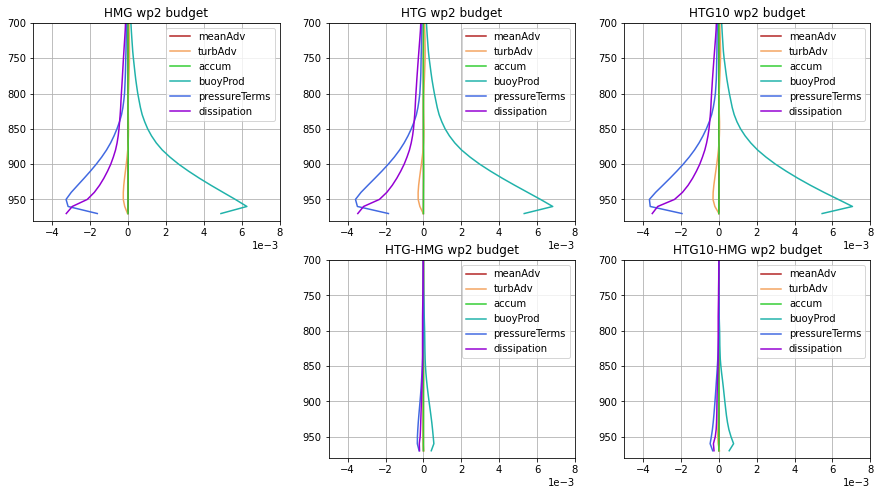

In [25]:
## Real surface:
startHr = 12
endHr   = 18
# wp2_budget_plot(lowPct_day2,startHr,endHr,0.007,-0.005,'levInterp')
wp2_budget_plot(highPct_day2,startHr,endHr,0.008,-0.005,'levInterp')

In [26]:
## Plot budget terms 

def wprtp_budget_plot(DS,startHr,endHr,xmax,xmin,levName):
    
    # ------- dDry days ----------
    iTimeSel = np.where((DS["time.hour"].values>=startHr) & 
                        (DS["time.hour"].values<=endHr))[0]

    hourlyMean_DS = DS.isel(time=iTimeSel).mean(dim='time')

    print('Means computed over the inclusive period of %i to %i.' % (startHr, endHr))
    
    termNames = ['meanAdv','turbAdv','turbProd','accum','buoyProd','pressureTerms','dissipation']

    if levName=='ilev':
        budgetNames = ['wprtp_ma','wprtp_ta','wprtp_tp','wprtp_ac','wprtp_bp',
                       'wprtp_pr1','wprtp_pr2','wprtp_pr3','wprtp_dp1'] 
        
    elif levName=='levInterp':
        budgetNames = ['wprtp_ma_interp','wprtp_ta_interp','wprtp_tp_interp','wprtp_ac_interp','wprtp_bp_interp',
                       'wprtp_pr1_interp','wprtp_pr2_interp','wprtp_pr3_interp','wprtp_dp1_interp'] 
    ## Select each case
    HMGvars   = hourlyMean_DS.sel(case='HMG')[budgetNames]
    HTGvars   = hourlyMean_DS.sel(case='HTG*01')[budgetNames]
    HTG10vars = hourlyMean_DS.sel(case='HTG*10')[budgetNames]
        
    
    fig,axs = plt.subplots(2,3, figsize=(15,8))
    axs = axs.ravel()

    colorsList = np.asarray(['firebrick','sandybrown','olivedrab','limegreen','lightseagreen','royalblue','darkviolet'])

    ## This part is prone to human error - 
    ##    would be great to have a more concrete way to identify terms than indexing the lists above
    
    #Mean Advection
    axs[0].plot( np.squeeze(HMGvars[budgetNames[0]].values),   HMGvars[levName].values, color=colorsList[0], label=termNames[0])
    axs[1].plot( np.squeeze(HTGvars[budgetNames[0]].values),   HTGvars[levName].values, color=colorsList[0], label=termNames[0])
    axs[2].plot( np.squeeze(HTG10vars[budgetNames[0]].values), HTG10vars[levName].values, color=colorsList[0], label=termNames[0])

    axs[4].plot( np.squeeze(HTGvars[budgetNames[0]].values-HMGvars[budgetNames[0]].values),   HTGvars[levName].values, color=colorsList[0], label=termNames[0])
    axs[5].plot( np.squeeze(HTG10vars[budgetNames[0]].values-HMGvars[budgetNames[0]].values), HTGvars[levName].values, color=colorsList[0], label=termNames[0])

    
    #TurbulentAdvection
    axs[0].plot( np.squeeze(HMGvars[budgetNames[1]].values),   HMGvars[levName].values, color=colorsList[1], label=termNames[1])
    axs[1].plot( np.squeeze(HTGvars[budgetNames[1]].values),   HTGvars[levName].values, color=colorsList[1], label=termNames[1])
    axs[2].plot( np.squeeze(HTG10vars[budgetNames[1]].values), HTG10vars[levName].values, color=colorsList[1], label=termNames[1])

    axs[4].plot( np.squeeze(HTGvars[budgetNames[1]].values-HMGvars[budgetNames[1]].values),   HTGvars[levName].values, color=colorsList[1], label=termNames[1])
    axs[5].plot( np.squeeze(HTG10vars[budgetNames[1]].values-HMGvars[budgetNames[1]].values), HTGvars[levName].values, color=colorsList[1], label=termNames[1])

        
    #TurbulentProduction
    axs[0].plot( np.squeeze(HMGvars[budgetNames[2]].values),   HMGvars[levName].values, color=colorsList[2], label=termNames[2])
    axs[1].plot( np.squeeze(HTGvars[budgetNames[2]].values),   HTGvars[levName].values, color=colorsList[2], label=termNames[2])
    axs[2].plot( np.squeeze(HTG10vars[budgetNames[2]].values), HTG10vars[levName].values, color=colorsList[2], label=termNames[2])

    axs[4].plot( np.squeeze(HTGvars[budgetNames[2]].values-HMGvars[budgetNames[2]].values),   HTGvars[levName].values, color=colorsList[2], label=termNames[2])
    axs[5].plot( np.squeeze(HTG10vars[budgetNames[2]].values-HMGvars[budgetNames[2]].values), HTGvars[levName].values, color=colorsList[2], label=termNames[2])

        
    #Accumulation
    axs[0].plot( np.squeeze(HMGvars[budgetNames[3]].values),   HMGvars[levName].values, color=colorsList[3], label=termNames[3])
    axs[1].plot( np.squeeze(HTGvars[budgetNames[3]].values),   HTGvars[levName].values, color=colorsList[3], label=termNames[3])
    axs[2].plot( np.squeeze(HTG10vars[budgetNames[3]].values), HTG10vars[levName].values, color=colorsList[3], label=termNames[3])

    axs[4].plot( np.squeeze(HTGvars[budgetNames[3]].values-HMGvars[budgetNames[3]].values),   HTGvars[levName].values, color=colorsList[3], label=termNames[3])
    axs[5].plot( np.squeeze(HTG10vars[budgetNames[3]].values-HMGvars[budgetNames[3]].values), HTGvars[levName].values, color=colorsList[3], label=termNames[3])

                
    #BuoyancyProduction
    axs[0].plot( np.squeeze(HMGvars[budgetNames[4]].values),   HMGvars[levName].values, color=colorsList[4], label=termNames[4])
    axs[1].plot( np.squeeze(HTGvars[budgetNames[4]].values),   HTGvars[levName].values, color=colorsList[4], label=termNames[4])
    axs[2].plot( np.squeeze(HTG10vars[budgetNames[4]].values), HTG10vars[levName].values, color=colorsList[4], label=termNames[4])

    axs[4].plot( np.squeeze(HTGvars[budgetNames[4]].values-HMGvars[budgetNames[4]].values),   HTGvars[levName].values, color=colorsList[4], label=termNames[4])
    axs[5].plot( np.squeeze(HTG10vars[budgetNames[4]].values-HMGvars[budgetNames[4]].values), HTGvars[levName].values, color=colorsList[4], label=termNames[4])

        
    #Pressure Terms
    axs[0].plot( np.squeeze(HMGvars[budgetNames[5]].values+HMGvars[budgetNames[6]].values+HMGvars[budgetNames[7]].values), 
                HMGvars[levName].values, 
                color=colorsList[5], label=termNames[5])
    axs[1].plot( np.squeeze(HTGvars[budgetNames[5]].values+HTGvars[budgetNames[6]].values+HTGvars[budgetNames[7]].values), 
            HTGvars[levName].values, 
            color=colorsList[5], label=termNames[5])
    axs[2].plot( np.squeeze(HTG10vars[budgetNames[5]].values+HTG10vars[budgetNames[6]].values+HTG10vars[budgetNames[7]].values), 
            HTG10vars[levName].values, 
            color=colorsList[5], label=termNames[5])
    
    axs[4].plot( np.squeeze(HTGvars[budgetNames[5]].values+HTGvars[budgetNames[6]].values+HTGvars[budgetNames[7]].values)-np.squeeze(HMGvars[budgetNames[5]].values+HMGvars[budgetNames[6]].values+HMGvars[budgetNames[7]].values), 
            HTGvars[levName].values, 
            color=colorsList[5], label=termNames[5])
    axs[5].plot( np.squeeze(HTG10vars[budgetNames[5]].values+HTG10vars[budgetNames[6]].values+HTG10vars[budgetNames[7]].values)-np.squeeze(HMGvars[budgetNames[5]].values+HMGvars[budgetNames[6]].values+HMGvars[budgetNames[7]].values), 
            HTGvars[levName].values, 
            color=colorsList[5], label=termNames[5])
 
    #Dissipation Terms
    axs[0].plot( np.squeeze(HMGvars[budgetNames[8]].values),   HMGvars[levName].values, color=colorsList[6], label=termNames[6])
    axs[1].plot( np.squeeze(HTGvars[budgetNames[8]].values),   HTGvars[levName].values, color=colorsList[6], label=termNames[6])
    axs[2].plot( np.squeeze(HTG10vars[budgetNames[8]].values), HTG10vars[levName].values, color=colorsList[6], label=termNames[6])

    axs[4].plot( np.squeeze(HTGvars[budgetNames[8]].values-HMGvars[budgetNames[8]].values),   HTGvars[levName].values, color=colorsList[6], label=termNames[6])
    axs[5].plot( np.squeeze(HTG10vars[budgetNames[8]].values-HMGvars[budgetNames[8]].values), HTGvars[levName].values, color=colorsList[6], label=termNames[6])

    
    # Consistent settings across subplots 
    fig.delaxes(axs[3])
    
    axs[0].set_ylim([700,980])
    axs[0].set_xlim([xmin,xmax])
    axs[0].invert_yaxis()
    axs[0].legend()
    axs[0].set_title('HMG wprtp budget')

    axs[1].set_ylim([700,980])
    axs[1].set_xlim([xmin,xmax])
    axs[1].invert_yaxis()
    axs[1].legend()
    axs[1].set_title('HTG wprtp budget')

    axs[2].set_ylim([700,980])
    axs[2].set_xlim([xmin,xmax])
    axs[2].invert_yaxis()
    axs[2].legend()
    axs[2].set_title('HTG10 wprtp budget')
    
    axs[4].set_ylim([700,980])
    axs[4].set_xlim([xmin,xmax])
    axs[4].invert_yaxis()
    axs[4].legend()
    axs[4].set_title('HTG-HMG wprtp budget')
    
    axs[5].set_ylim([700,980])
    axs[5].set_xlim([xmin,xmax])
    axs[5].invert_yaxis()
    axs[5].legend()
    axs[5].set_title('HTG10-HMG wprtp budget')
    
    
    axs[0].ticklabel_format(style='sci',scilimits=(-2,4),axis='x')
    axs[1].ticklabel_format(style='sci',scilimits=(-2,4),axis='x')
    axs[2].ticklabel_format(style='sci',scilimits=(-2,4),axis='x')
    axs[4].ticklabel_format(style='sci',scilimits=(-2,4),axis='x')
    axs[5].ticklabel_format(style='sci',scilimits=(-2,4),axis='x')
    
    axs[0].grid()
    axs[1].grid()
    axs[2].grid()
    axs[4].grid()
    axs[5].grid()
    
    return


Means computed over the inclusive period of 12 to 18.


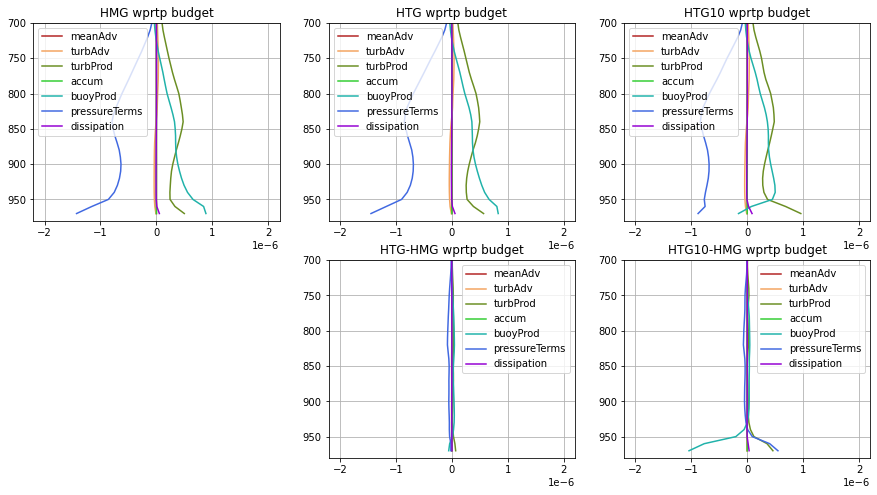

In [28]:
## Real surface:
startHr = 12
endHr   = 18
# wprtp_budget_plot(lowPct_day2,startHr,endHr,0.000003,-0.000005,'levInterp')
wprtp_budget_plot(highPct_day2,startHr,endHr,0.0000022,-0.0000022,'levInterp')

In [29]:
## Plot budget terms 

def wpthlp_budget_plot(DS,startHr,endHr,xmax,xmin,levName):
    
    # ------- dDry days ----------
    iTimeSel = np.where((DS["time.hour"].values>=startHr) & 
                        (DS["time.hour"].values<=endHr))[0]

    hourlyMean_DS = DS.isel(time=iTimeSel).mean(dim='time')

    print('Means computed over the inclusive period of %i to %i.' % (startHr, endHr))
    
    termNames = ['meanAdv','turbAdv','turbProd','accum','buoyProd','pressureTerms','dissipation']

    if levName=='ilev':
        budgetNames = ['wpthlp_ma','wpthlp_ta','wpthlp_tp','wpthlp_ac','wpthlp_bp',
                       'wpthlp_pr1','wpthlp_pr2','wpthlp_pr3','wpthlp_dp1'] 
        
    elif levName=='levInterp':
        budgetNames = ['wpthlp_ma_interp','wpthlp_ta_interp','wpthlp_tp_interp','wpthlp_ac_interp','wpthlp_bp_interp',
                       'wpthlp_pr1_interp','wpthlp_pr2_interp','wpthlp_pr3_interp','wpthlp_dp1_interp'] 
    ## Select each case
    HMGvars   = hourlyMean_DS.sel(case='HMG')[budgetNames]
    HTGvars   = hourlyMean_DS.sel(case='HTG*01')[budgetNames]
    HTG10vars = hourlyMean_DS.sel(case='HTG*10')[budgetNames]
        
    
    fig,axs = plt.subplots(2,3, figsize=(15,8))
    axs = axs.ravel()

    colorsList = np.asarray(['firebrick','sandybrown','olivedrab','limegreen','lightseagreen','royalblue','darkviolet'])

    ## This part is prone to human error - 
    ##    would be great to have a more concrete way to identify terms than indexing the lists above
    
    #Mean Advection
    axs[0].plot( np.squeeze(HMGvars[budgetNames[0]].values),   HMGvars[levName].values, color=colorsList[0], label=termNames[0])
    axs[1].plot( np.squeeze(HTGvars[budgetNames[0]].values),   HTGvars[levName].values, color=colorsList[0], label=termNames[0])
    axs[2].plot( np.squeeze(HTG10vars[budgetNames[0]].values), HTG10vars[levName].values, color=colorsList[0], label=termNames[0])

    axs[4].plot( np.squeeze(HTGvars[budgetNames[0]].values-HMGvars[budgetNames[0]].values),   HTGvars[levName].values, color=colorsList[0], label=termNames[0])
    axs[5].plot( np.squeeze(HTG10vars[budgetNames[0]].values-HMGvars[budgetNames[0]].values), HTGvars[levName].values, color=colorsList[0], label=termNames[0])

    
    #TurbulentAdvection
    axs[0].plot( np.squeeze(HMGvars[budgetNames[1]].values),   HMGvars[levName].values, color=colorsList[1], label=termNames[1])
    axs[1].plot( np.squeeze(HTGvars[budgetNames[1]].values),   HTGvars[levName].values, color=colorsList[1], label=termNames[1])
    axs[2].plot( np.squeeze(HTG10vars[budgetNames[1]].values), HTG10vars[levName].values, color=colorsList[1], label=termNames[1])

    axs[4].plot( np.squeeze(HTGvars[budgetNames[1]].values-HMGvars[budgetNames[1]].values),   HTGvars[levName].values, color=colorsList[1], label=termNames[1])
    axs[5].plot( np.squeeze(HTG10vars[budgetNames[1]].values-HMGvars[budgetNames[1]].values), HTGvars[levName].values, color=colorsList[1], label=termNames[1])

        
    #TurbulentProduction
    axs[0].plot( np.squeeze(HMGvars[budgetNames[2]].values),   HMGvars[levName].values, color=colorsList[2], label=termNames[2])
    axs[1].plot( np.squeeze(HTGvars[budgetNames[2]].values),   HTGvars[levName].values, color=colorsList[2], label=termNames[2])
    axs[2].plot( np.squeeze(HTG10vars[budgetNames[2]].values), HTG10vars[levName].values, color=colorsList[2], label=termNames[2])

    axs[4].plot( np.squeeze(HTGvars[budgetNames[2]].values-HMGvars[budgetNames[2]].values),   HTGvars[levName].values, color=colorsList[2], label=termNames[2])
    axs[5].plot( np.squeeze(HTG10vars[budgetNames[2]].values-HMGvars[budgetNames[2]].values), HTGvars[levName].values, color=colorsList[2], label=termNames[2])

        
    #Accumulation
    axs[0].plot( np.squeeze(HMGvars[budgetNames[3]].values),   HMGvars[levName].values, color=colorsList[3], label=termNames[3])
    axs[1].plot( np.squeeze(HTGvars[budgetNames[3]].values),   HTGvars[levName].values, color=colorsList[3], label=termNames[3])
    axs[2].plot( np.squeeze(HTG10vars[budgetNames[3]].values), HTG10vars[levName].values, color=colorsList[3], label=termNames[3])

    axs[4].plot( np.squeeze(HTGvars[budgetNames[3]].values-HMGvars[budgetNames[3]].values),   HTGvars[levName].values, color=colorsList[3], label=termNames[3])
    axs[5].plot( np.squeeze(HTG10vars[budgetNames[3]].values-HMGvars[budgetNames[3]].values), HTGvars[levName].values, color=colorsList[3], label=termNames[3])

                
    #BuoyancyProduction
    axs[0].plot( np.squeeze(HMGvars[budgetNames[4]].values),   HMGvars[levName].values, color=colorsList[4], label=termNames[4])
    axs[1].plot( np.squeeze(HTGvars[budgetNames[4]].values),   HTGvars[levName].values, color=colorsList[4], label=termNames[4])
    axs[2].plot( np.squeeze(HTG10vars[budgetNames[4]].values), HTG10vars[levName].values, color=colorsList[4], label=termNames[4])

    axs[4].plot( np.squeeze(HTGvars[budgetNames[4]].values-HMGvars[budgetNames[4]].values),   HTGvars[levName].values, color=colorsList[4], label=termNames[4])
    axs[5].plot( np.squeeze(HTG10vars[budgetNames[4]].values-HMGvars[budgetNames[4]].values), HTGvars[levName].values, color=colorsList[4], label=termNames[4])

        
    #Pressure Terms
    axs[0].plot( np.squeeze(HMGvars[budgetNames[5]].values+HMGvars[budgetNames[6]].values+HMGvars[budgetNames[7]].values), 
                HMGvars[levName].values, 
                color=colorsList[5], label=termNames[5])
    axs[1].plot( np.squeeze(HTGvars[budgetNames[5]].values+HTGvars[budgetNames[6]].values+HTGvars[budgetNames[7]].values), 
            HTGvars[levName].values, 
            color=colorsList[5], label=termNames[5])
    axs[2].plot( np.squeeze(HTG10vars[budgetNames[5]].values+HTG10vars[budgetNames[6]].values+HTG10vars[budgetNames[7]].values), 
            HTG10vars[levName].values, 
            color=colorsList[5], label=termNames[5])
    
    axs[4].plot( np.squeeze(HTGvars[budgetNames[5]].values+HTGvars[budgetNames[6]].values+HTGvars[budgetNames[7]].values)-np.squeeze(HMGvars[budgetNames[5]].values+HMGvars[budgetNames[6]].values+HMGvars[budgetNames[7]].values), 
            HTGvars[levName].values, 
            color=colorsList[5], label=termNames[5])
    axs[5].plot( np.squeeze(HTG10vars[budgetNames[5]].values+HTG10vars[budgetNames[6]].values+HTG10vars[budgetNames[7]].values)-np.squeeze(HMGvars[budgetNames[5]].values+HMGvars[budgetNames[6]].values+HMGvars[budgetNames[7]].values), 
            HTGvars[levName].values, 
            color=colorsList[5], label=termNames[5])
 
    #Dissipation Terms
    axs[0].plot( np.squeeze(HMGvars[budgetNames[8]].values),   HMGvars[levName].values, color=colorsList[6], label=termNames[6])
    axs[1].plot( np.squeeze(HTGvars[budgetNames[8]].values),   HTGvars[levName].values, color=colorsList[6], label=termNames[6])
    axs[2].plot( np.squeeze(HTG10vars[budgetNames[8]].values), HTG10vars[levName].values, color=colorsList[6], label=termNames[6])

    axs[4].plot( np.squeeze(HTGvars[budgetNames[8]].values-HMGvars[budgetNames[8]].values),   HTGvars[levName].values, color=colorsList[6], label=termNames[6])
    axs[5].plot( np.squeeze(HTG10vars[budgetNames[8]].values-HMGvars[budgetNames[8]].values), HTGvars[levName].values, color=colorsList[6], label=termNames[6])

    
    # Consistent settings across subplots 
    fig.delaxes(axs[3])
    
    axs[0].set_ylim([700,980])
    axs[0].set_xlim([xmin,xmax])
    axs[0].invert_yaxis()
    axs[0].legend()
    axs[0].set_title('HMG wpthlp budget')

    axs[1].set_ylim([700,980])
    axs[1].set_xlim([xmin,xmax])
    axs[1].invert_yaxis()
    axs[1].legend()
    axs[1].set_title('HTG wpthlp budget')

    axs[2].set_ylim([700,980])
    axs[2].set_xlim([xmin,xmax])
    axs[2].invert_yaxis()
    axs[2].legend()
    axs[2].set_title('HTG10 wprtp budget')
    
    axs[4].set_ylim([700,980])
    axs[4].set_xlim([xmin,xmax])
    axs[4].invert_yaxis()
    axs[4].legend()
    axs[4].set_title('HTG-HMG wpthlp budget')
    
    axs[5].set_ylim([700,980])
    axs[5].set_xlim([xmin,xmax])
    axs[5].invert_yaxis()
    axs[5].legend()
    axs[5].set_title('HTG10-HMG wpthlp budget')
    
    
    axs[0].ticklabel_format(style='sci',scilimits=(-2,4),axis='x')
    axs[1].ticklabel_format(style='sci',scilimits=(-2,4),axis='x')
    axs[2].ticklabel_format(style='sci',scilimits=(-2,4),axis='x')
    axs[4].ticklabel_format(style='sci',scilimits=(-2,4),axis='x')
    axs[5].ticklabel_format(style='sci',scilimits=(-2,4),axis='x')
    
    axs[0].grid()
    axs[1].grid()
    axs[2].grid()
    axs[4].grid()
    axs[5].grid()
    
    return


Means computed over the inclusive period of 12 to 18.


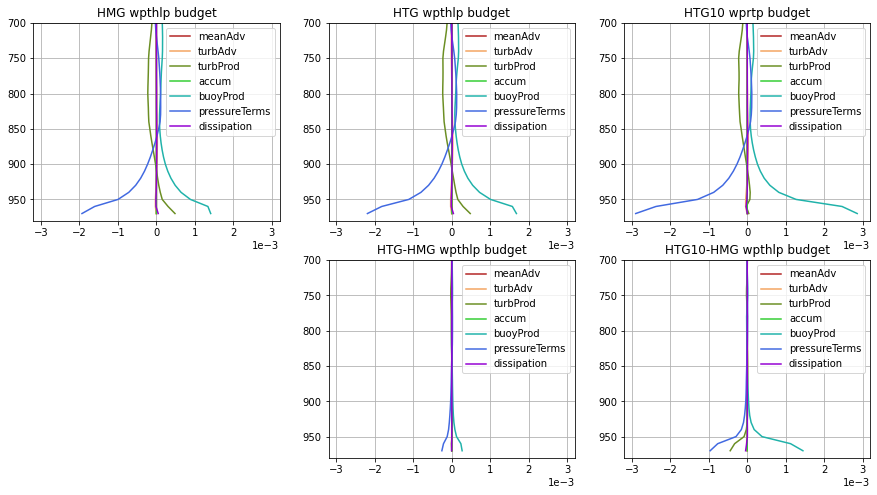

In [31]:
## Real surface:
startHr = 12
endHr   = 18
# wpthlp_budget_plot(lowPct_day2,startHr,endHr,0.0055,-0.0055,'levInterp')
wpthlp_budget_plot(highPct_day2,startHr,endHr,0.0032,-0.0032,'levInterp')


In [41]:
## Plot budget terms 

def thlp2_budget_plot(DS,startHr,endHr,xmax,xmin,levName):
    
    # ------- dDry days ----------
    iTimeSel = np.where((DS["time.hour"].values>=startHr) & 
                        (DS["time.hour"].values<=endHr))[0]

    hourlyMean_DS = DS.isel(time=iTimeSel).mean(dim='time')

    print('Means computed over the inclusive period of %i to %i.' % (startHr, endHr))
    
    termNames = ['meanAdv','turbAdv','turbProd','dissipation']

    if levName=='ilev':
        budgetNames = ['thlp2_ma','thlp2_ta','thlp2_tp','thlp2_dp1','thlp2_dp2'] 
        
    elif levName=='levInterp':
        budgetNames = ['thlp2_ma_interp','thlp2_ta_interp','thlp2_tp_interp','thlp2_dp1_interp','thlp2_dp2_interp'] 
        
    ## Select each case
    HMGvars   = hourlyMean_DS.sel(case='HMG')[budgetNames]
    HTGvars   = hourlyMean_DS.sel(case='HTG*01')[budgetNames]
    HTG10vars = hourlyMean_DS.sel(case='HTG*10')[budgetNames]
        
    
    fig,axs = plt.subplots(2,3, figsize=(15,8))
    axs = axs.ravel()

    colorsList = np.asarray(['firebrick','sandybrown','olivedrab','darkviolet'])

    ## This part is prone to human error - 
    ##    would be great to have a more concrete way to identify terms than indexing the lists above
    
    #Mean Advection
    axs[0].plot( np.squeeze(HMGvars[budgetNames[0]].values),   HMGvars[levName].values, color=colorsList[0], label=termNames[0])
    axs[1].plot( np.squeeze(HTGvars[budgetNames[0]].values),   HTGvars[levName].values, color=colorsList[0], label=termNames[0])
    axs[2].plot( np.squeeze(HTG10vars[budgetNames[0]].values), HTG10vars[levName].values, color=colorsList[0], label=termNames[0])

    axs[4].plot( np.squeeze(HTGvars[budgetNames[0]].values-HMGvars[budgetNames[0]].values),   HTGvars[levName].values, color=colorsList[0], label=termNames[0])
    axs[5].plot( np.squeeze(HTG10vars[budgetNames[0]].values-HMGvars[budgetNames[0]].values), HTGvars[levName].values, color=colorsList[0], label=termNames[0])

    
    #TurbulentAdvection
    axs[0].plot( np.squeeze(HMGvars[budgetNames[1]].values),   HMGvars[levName].values, color=colorsList[1], label=termNames[1])
    axs[1].plot( np.squeeze(HTGvars[budgetNames[1]].values),   HTGvars[levName].values, color=colorsList[1], label=termNames[1])
    axs[2].plot( np.squeeze(HTG10vars[budgetNames[1]].values), HTG10vars[levName].values, color=colorsList[1], label=termNames[1])

    axs[4].plot( np.squeeze(HTGvars[budgetNames[1]].values-HMGvars[budgetNames[1]].values),   HTGvars[levName].values, color=colorsList[1], label=termNames[1])
    axs[5].plot( np.squeeze(HTG10vars[budgetNames[1]].values-HMGvars[budgetNames[1]].values), HTGvars[levName].values, color=colorsList[1], label=termNames[1])

        
    #TurbulentProduction
    axs[0].plot( np.squeeze(HMGvars[budgetNames[2]].values),   HMGvars[levName].values, color=colorsList[2], label=termNames[2])
    axs[1].plot( np.squeeze(HTGvars[budgetNames[2]].values),   HTGvars[levName].values, color=colorsList[2], label=termNames[2])
    axs[2].plot( np.squeeze(HTG10vars[budgetNames[2]].values), HTG10vars[levName].values, color=colorsList[2], label=termNames[2])

    axs[4].plot( np.squeeze(HTGvars[budgetNames[2]].values-HMGvars[budgetNames[2]].values),   HTGvars[levName].values, color=colorsList[2], label=termNames[2])
    axs[5].plot( np.squeeze(HTG10vars[budgetNames[2]].values-HMGvars[budgetNames[2]].values), HTGvars[levName].values, color=colorsList[2], label=termNames[2])

    #Dissipation Terms
    axs[0].plot( np.squeeze(HMGvars[budgetNames[3]].values+HMGvars[budgetNames[4]].values), 
                HMGvars[levName].values, 
                color=colorsList[3], label=termNames[3])
    axs[1].plot( np.squeeze(HTGvars[budgetNames[3]].values+HTGvars[budgetNames[4]].values), 
                HTGvars[levName].values, 
                color=colorsList[3], label=termNames[3])
    axs[2].plot( np.squeeze(HTG10vars[budgetNames[3]].values+HTG10vars[budgetNames[4]].values), 
                HTG10vars[levName].values, 
                color=colorsList[3], label=termNames[3])
    
    axs[4].plot( np.squeeze(HTGvars[budgetNames[3]].values+HTGvars[budgetNames[4]].values)-np.squeeze(HMGvars[budgetNames[3]].values+HMGvars[budgetNames[4]].values), 
                HTGvars[levName].values, 
                color=colorsList[3], label=termNames[3])
    axs[5].plot( np.squeeze(HTG10vars[budgetNames[3]].values+HTG10vars[budgetNames[4]].values)-np.squeeze(HMGvars[budgetNames[3]].values+HMGvars[budgetNames[4]].values), 
                HTGvars[levName].values, 
                color=colorsList[3], label=termNames[3])
    
    
    # Consistent settings across subplots 
    fig.delaxes(axs[3])
    
    axs[0].set_ylim([700,980])
    axs[0].set_xlim([xmin,xmax])
    axs[0].invert_yaxis()
    axs[0].legend()
    axs[0].set_title('HMG thlp2 budget')

    axs[1].set_ylim([700,980])
    axs[1].set_xlim([xmin,xmax])
    axs[1].invert_yaxis()
    axs[1].legend()
    axs[1].set_title('HTG thlp2 budget')

    axs[2].set_ylim([700,980])
    axs[2].set_xlim([xmin,xmax])
    axs[2].invert_yaxis()
    axs[2].legend()
    axs[2].set_title('HTG10 thlp2 budget')
    
    axs[4].set_ylim([700,980])
    axs[4].set_xlim([xmin,xmax])
    axs[4].invert_yaxis()
    axs[4].legend()
    axs[4].set_title('HTG-HMG thlp2 budget')
    
    axs[5].set_ylim([700,980])
    axs[5].set_xlim([xmin,xmax])
    axs[5].invert_yaxis()
    axs[5].legend()
    axs[5].set_title('HTG10-HMG thlp2 budget')
    
    
    axs[0].ticklabel_format(style='sci',scilimits=(-2,4),axis='x')
    axs[1].ticklabel_format(style='sci',scilimits=(-2,4),axis='x')
    axs[2].ticklabel_format(style='sci',scilimits=(-2,4),axis='x')
    axs[4].ticklabel_format(style='sci',scilimits=(-2,4),axis='x')
    axs[5].ticklabel_format(style='sci',scilimits=(-2,4),axis='x')
    
    axs[0].grid()
    axs[1].grid()
    axs[2].grid()
    axs[4].grid()
    axs[5].grid()
    
    return


Means computed over the inclusive period of 12 to 18.
Means computed over the inclusive period of 12 to 18.


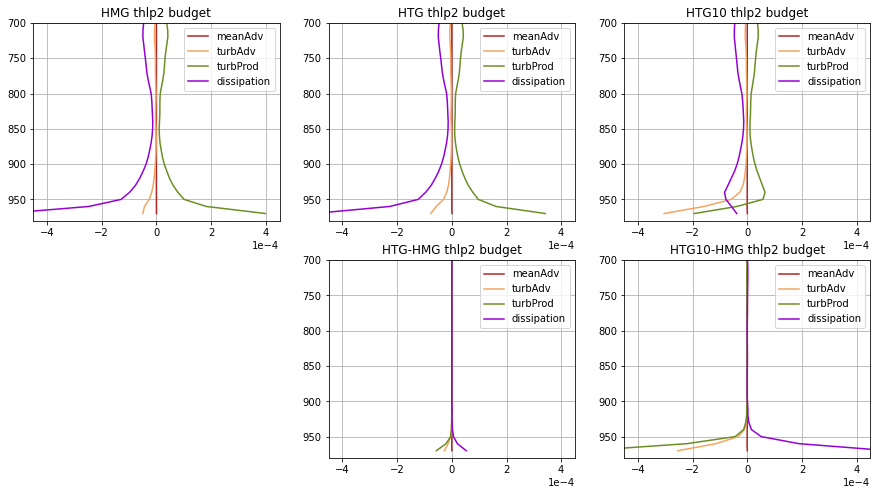

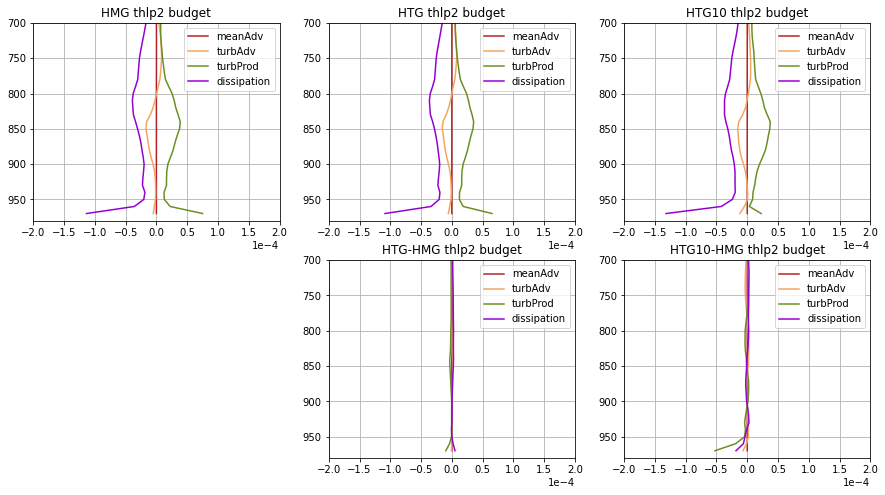

In [46]:
## Real surface:
startHr = 12
endHr   = 18
thlp2_budget_plot(lowPct_day2,startHr,endHr,0.00045,-0.00045,'levInterp')
thlp2_budget_plot(highPct_day2,startHr,endHr,0.0002,-0.0002,'levInterp')
